Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

<b>Описание данных</b>

Данные состоят из файлов, полученных из разных источников:

data_arc.csv — данные об электродах;

data_bulk.csv — данные о подаче сыпучих материалов (объём);

data_bulk_time.csv — данные о подаче сыпучих материалов (время);

data_gas.csv — данные о продувке сплава газом;

data_temp.csv — результаты измерения температуры;

data_wire.csv — данные о проволочных материалах (объём);

data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

In [804]:
!pip install pyod
!pip install xgboost
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures
from pyod.models.knn import KNN
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

%matplotlib inline

# Изучение данных

### Данные об электродах

In [694]:
### Импорт данных

try:
    data_arc = pd.read_csv('/Users/Ivan/data_arc.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.info()
data_arc.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [695]:
data_arc[data_arc['Реактивная мощность'] < 0]['Реактивная мощность']

9780   -715.504924
Name: Реактивная мощность, dtype: float64

In [696]:
len(data_arc['key'].unique())

3214

In [697]:
data_arc.tail(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14866,3240,2019-09-01 02:35:24,2019-09-01 02:37:25,0.411601,0.274390
14867,3240,2019-09-01 02:40:55,2019-09-01 02:43:28,0.521811,0.378517
14868,3240,2019-09-01 03:08:38,2019-09-01 03:11:08,0.518065,0.528780
14869,3240,2019-09-01 03:12:34,2019-09-01 03:17:08,0.983723,0.884585
14870,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.548882,0.416994
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


<AxesSubplot:>

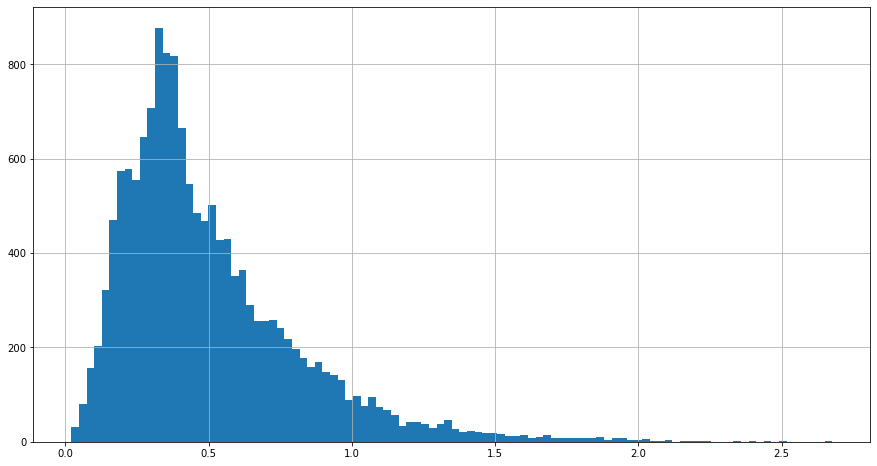

In [698]:
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100, figsize=(15,8))

<AxesSubplot:>

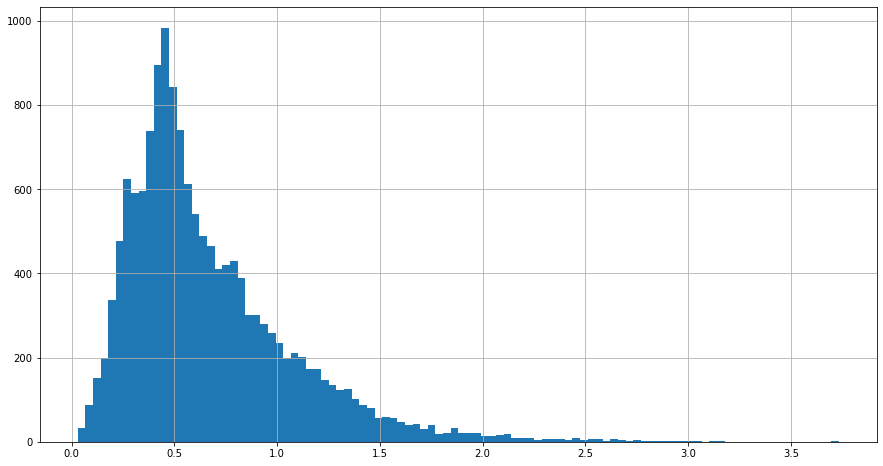

In [699]:
data_arc['Активная мощность'].hist(bins=100, figsize=(15,8))

<b>Выводы:</b>

Есть аномалия в данных по реактивной мощности

Время в формат object перевести в datetime

Данные активной и реактивной мощности смещенны влево

### Данные о подаче сыпучих материалов (объём)

In [700]:
### Импорт данных

try:
    data_bulk = pd.read_csv('/Users/Ivan/data_bulk.csv')
except:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

data_bulk.info()
data_bulk.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [701]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [702]:
len(data_bulk['key'].unique())

3129

In [703]:
data_bulk.set_index('key', inplace=True)

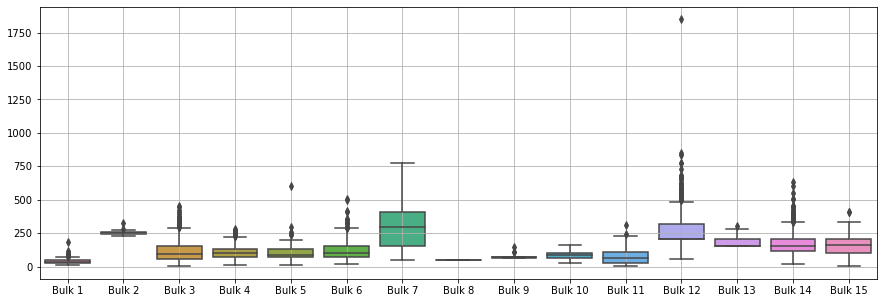

In [704]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_bulk)
plt.grid();

In [705]:
try:
    data_bulk = pd.read_csv('/Users/Ivan/data_bulk.csv')
except:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

<b>Выводы</b>

Столбец key перевезти в целочисленный формат

Имеется большие пропуски данных, скорее всего это связано с добавлением различного количества сыпучих материалов в смеси, в том числе и не добавлением, возможно это и ошибки датчика, но данные восстановить корректно невозможно.

Данные перевезти из Float в int Есть пропуски по ключам, возможно данные потерянны.

Материал под номером 8 был добавлен всего в одну партию. Из оставшихся материалов наименьшее количество использований характерно для материалов 2, 9 и 13, они добавлялись в 22, 19 и 18 партий стали соответственно.

Явно ошибочных значений в представленной таблице нет - минимальный объем добавок во всех случаях положителен, максимальные объемы для большинства добавок составляют от 147 до 772, для материала 12 - максимальный объем составляет 1849, что выделяет его среди других значений.

### Данные о подаче сыпучих материалов (время)

In [706]:
### Импорт данных

try:
    data_bulk_time = pd.read_csv('/Users/Ivan/data_bulk_time.csv')
except:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

data_bulk_time.info()
data_bulk_time.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [707]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [708]:
len(data_bulk_time['key'].unique())

3129

<b> Выводы: </b>

Отсутствие данных времени похоже на отсутствие данных подачи. Необходимо сравнить NaN

### Данные о продувке сплава газом

In [709]:
### Импорт данных

try:
    data_gas = pd.read_csv('/Users/Ivan/data_gas.csv')
except:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    
data_gas.info()
data_gas.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [710]:
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [711]:
len(data_gas['key'].unique())

3239

<AxesSubplot:>

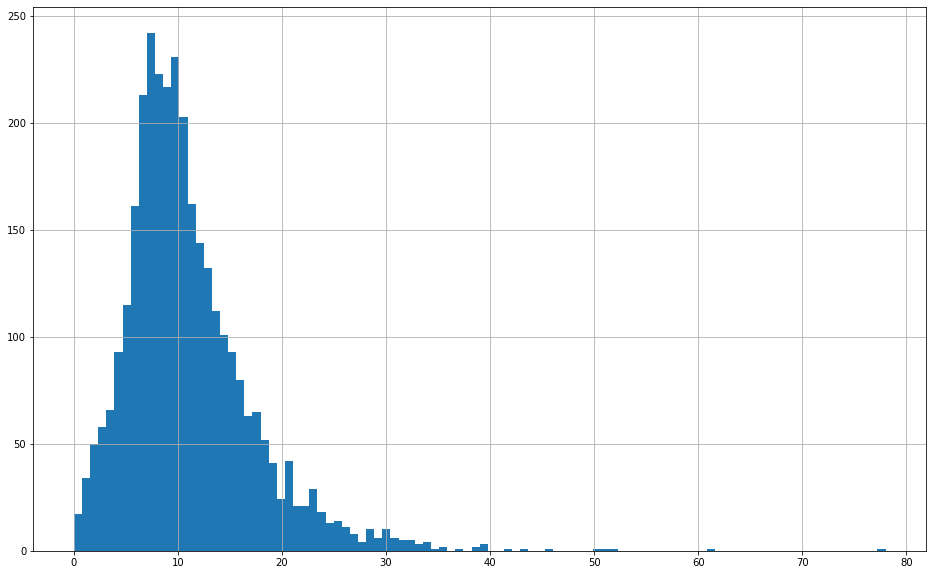

In [712]:
data_gas['Газ 1'].hist(bins=100, figsize=(16,10))

In [713]:
data_gas.set_index('key', inplace=True)

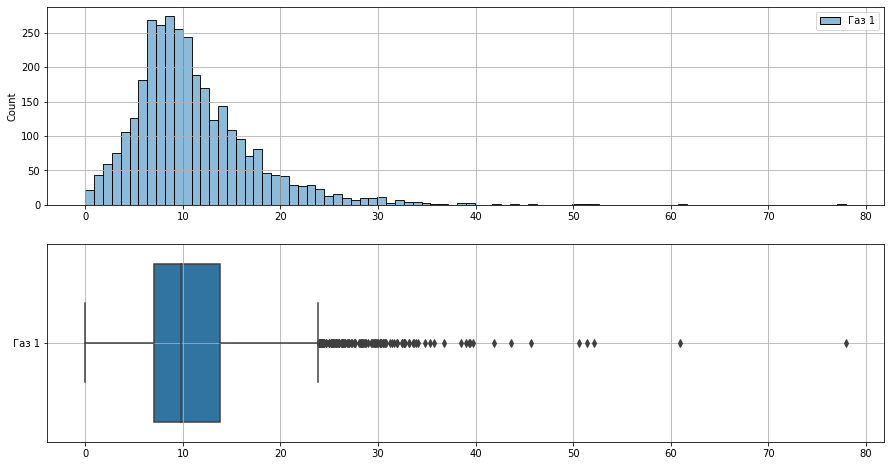

In [714]:
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
sns.histplot(data=data_gas)
plt.grid()
plt.subplot(2,1,2)
sns.boxplot(data=data_gas, orient='horizontal')
plt.grid()
plt.show()

In [715]:
try:
    data_gas = pd.read_csv('/Users/Ivan/data_gas.csv')
except:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

<b>Выводы:</b>

Данные по "Газ 1" смещенны влево

Объем подаваемого газа составляет в среднем 10 м3, в некоторых случаях достигая 40-80 м3. Т.к. на данном этапе нет информации о допустимых границах этого параметра технологическом процессе, оставим все имеющиеся значения без удаления.

### Результаты измерения температуры

In [716]:
### Импорт данных

try:
    data_temp = pd.read_csv('/Users/Ivan/data_temp.csv')
except:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    
data_temp.info()
data_temp.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [717]:
data_temp.tail(15)

,key,Время замера,Температура
15892,3239,2019-09-01 02:23:02,NaN
15893,3239,2019-09-01 02:24:15,NaN
15894,3240,2019-09-01 02:39:01,1617.0
15895,3240,2019-09-01 02:48:33,NaN
15896,3240,2019-09-01 03:03:21,NaN
15897,3240,2019-09-01 03:12:19,NaN
15898,3240,2019-09-01 03:19:09,NaN
15899,3240,2019-09-01 03:31:27,NaN
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN


In [718]:
len(data_temp['key'].unique())

3216

<AxesSubplot:>

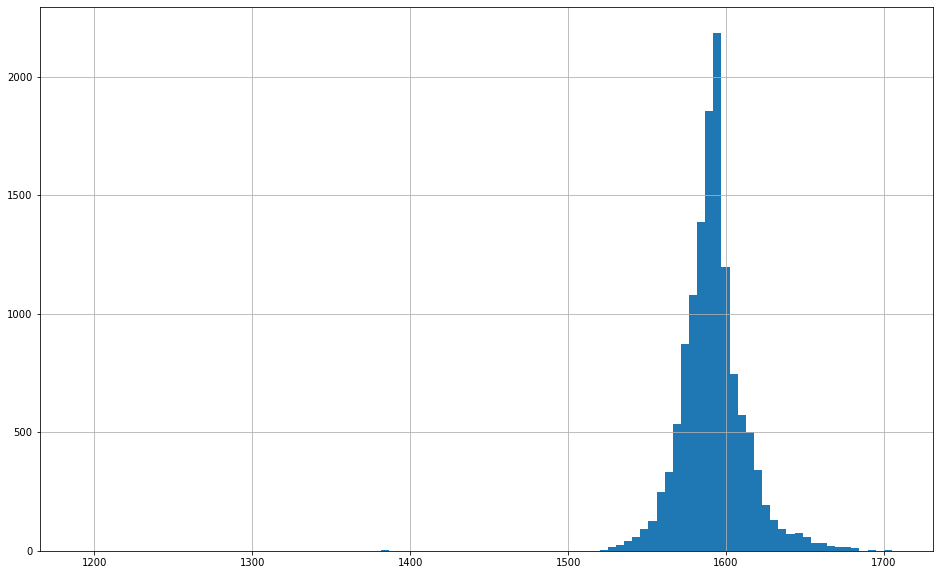

In [719]:
data_temp['Температура'].hist(bins=100, figsize=(16,10))

<b>Выводы:</b>

Имеются пропуски ключевого признака: последней температуры, скорее всего приведет к удалению всех данных по ключу

### Данные о проволочных материалах (объём)

In [720]:
### Импорт данных

try:
    data_wire = pd.read_csv('/Users/Ivan/data_wire.csv')
except:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

data_wire.info()
data_wire.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [721]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [722]:
len(data_wire['key'].unique())

3081

In [723]:
data_wire.set_index('key', inplace=True)

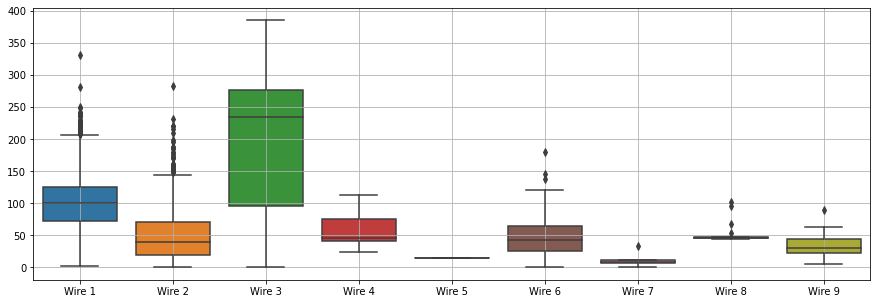

In [724]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_wire)
plt.grid();

In [725]:
try:
    data_wire = pd.read_csv('/Users/Ivan/data_wire.csv')
except:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

<b> Выводы: </b>
    
Явных выбросов в объеме проволочных материалов нет

В дальнейшем необходимо заменить пропуски на нули, просуммировать все значения объема для каждой партии, удалить материал под номером 5 с единичным значением.

### Данные о проволочных материалах (время)

In [726]:
### Импорт данных

try:
    data_wire_time = pd.read_csv('/Users/Ivan/data_wire_time.csv')
except:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.info()
data_wire_time.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [727]:
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [728]:
try:
    data_wire_time = pd.read_csv('/Users/Ivan/data_wire_time.csv')
except:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

<b> Выводы: </b>
    
Необходимо преобразовать время в формат datetime

### Выводы

Имеется большие пропуски данных, скорее всего это связано с добавлением различного количество сыпучих материалов в смеси, в том числе и не добавлением, возможно это и ошибки датчика, но данные восстановить корректно невозможно.

Во многих таблицах отсутствуют данные уникальных номеров партии 'key'.

Есть неправильное использование типа числа с плавающей точкой, времени в формате object вместо datetime.

Используется русскоязычные названия столбцов использование пробелов в названиях, что может приводить к ошибкам при обращении. Нужно переименовать.

Количество записей у одной партии для каждой таблицы может различаться.

Аномальное значение реактивной мощности в таблице data_arc.

Данные требуют предобработки и группировки по признаку key.

Данные распределены нормально со смещением влево
(В графике о температуре смысла мало так как это температура на различных этапах, и этапов может быть разное количество в каждой партии)

upd. в некоторых партиях время последнего замера температуры происходило до конца нагрева

### План решения задачи

Целевой признак конечная температура.

Подготовим данные.

Создадим таблицу, где просуммируем активную и реактивную мощность для каждой партии. Это снизит вычислительную нагрузку.

Создадим таблицу, где есть первый и последний замер температуры. (Если бы данные собирались четко по каждому этапу, то можно было бы использовать и промежуточную температуру)

Для таблиц data_bulk и data_wire заполним пропуски нулями (предполагаем, что пропуски не являются ошибкой, а означают отсутствие подачи)

Приведем типы данных к целочисленным для ускорения работы и временным для правильной отработки алгоритмов.

В каждой таблице преобразуем index в значение столбца key.

Выполним оценку мультиколлинеарности

Разобьем данные на train/test

Проведём обучение модели

Написани отчета

# Подготовка данных

## Переименуем столбцы на английский язык без пробелов

In [729]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
data_gas.columns = ['key', 'gas']
data_temp.columns = ['key', 'measurement_time', 'temperature']
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [730]:
# Избавимся от ошибоке в данных

data_arc = data_arc.query('reactive_power > 0')

## Создадим таблицу, где просуммируем активную и реактивную мощность для каждой партии.

In [731]:
data_arc_sum = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power'],
                             index='key',
                             aggfunc={'active_power': np.sum,
                                      'reactive_power': np.sum})
data_arc_sum.columns = ['sum_active_power','sum_reactive_power']
data_arc_sum

,sum_active_power,sum_reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643
...,...,...
3237,3.932467,2.828459
3238,2.106529,1.681182
3239,4.666754,3.111617


In [732]:
data_arc_mean = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power'],
                             index='key',
                             aggfunc={'active_power': np.mean,
                                      'reactive_power': np.mean})
data_arc_mean.columns = ['mean_active_power','mean_reactive_power']
data_arc_mean

,mean_active_power,mean_reactive_power
key,,
1,0.975629,0.636648
2,0.763150,0.499528
3,0.505176,0.319815
4,0.802313,0.515074
5,0.836793,0.563161
...,...,...
3237,0.786493,0.565692
3238,0.702176,0.560394
3239,0.583344,0.388952


## Создадим таблицу, где есть первый и последний замер температуры.

In [733]:
keys = []
for key in list(data_temp['key'].unique()):
    try:
        if (data_temp[data_temp['key'] == key]['measurement_time'].max() < 
            data_arc[data_arc['key'] == key]['end_time'].max()): # время последнего замера температуры происходило до конца нагрева
            keys.append(key)
    except:
        keys.append(key)
data_temp = data_temp.query('key not in @keys')

In [734]:
# избавимся от пропусков замеров

data_temp = data_temp.dropna()

In [735]:
# удаляем партии с одним замером температуры

for i in (data_temp['key'].unique()): 
    if (data_temp['key']==i).sum() < 2:
        data_temp = data_temp[data_temp.key != i]

In [736]:
data_temp_time = data_temp.pivot_table(index=['key'], values=('temperature', 'measurement_time'), aggfunc=['first', 'last'])

In [737]:
data_temp_time.columns = ['first_time', 'first_temperature', 'last_time', 'last_temperature']
data_temp_time

,first_time,first_temperature,last_time,last_temperature
key,,,,
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...
2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0
2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0
2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0


## Присваеваем индексам номер партии

In [738]:
data_bulk = data_bulk.set_index('key')
data_gas = data_gas.set_index('key')
data_wire = data_wire.set_index('key')

## Собираем все по индексу

In [739]:
data = pd.concat([data_temp_time, data_arc_sum, data_bulk, data_gas, data_wire], axis=1, sort=False)
data

,first_time,first_temperature,last_time,last_temperature,sum_active_power,sum_reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,4.878147,3.183241,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,3.052598,1.998112,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2.525882,1.599076,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,3.209250,2.060298,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,18.841219,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,3.347173,2.252643,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,5.413692,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.338997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [740]:
# Время замера не информативно так, как за это время происходилос разное колличество дествий

data = data.drop('first_time',axis=1)
data = data.drop('last_time',axis=1)
data = data.dropna(subset=['last_temperature'])
data = data.fillna(0)

In [741]:
data

,first_temperature,last_temperature,sum_active_power,sum_reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,3.210690,2.360777,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,1554.0,1591.0,4.203064,2.810185,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,1571.0,1589.0,2.212379,1.851269,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Исправляем типы данных

In [742]:
data['first_temperature']=data['first_temperature'].astype(int)
data['last_temperature']=data['last_temperature'].astype(int)
for i in range(1,16):
    data[f'bulk_{i}'] = data[f'bulk_{i}'].astype(int)

In [743]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   first_temperature   2344 non-null   int64  
 1   last_temperature    2344 non-null   int64  
 2   sum_active_power    2344 non-null   float64
 3   sum_reactive_power  2344 non-null   float64
 4   bulk_1              2344 non-null   int64  
 5   bulk_2              2344 non-null   int64  
 6   bulk_3              2344 non-null   int64  
 7   bulk_4              2344 non-null   int64  
 8   bulk_5              2344 non-null   int64  
 9   bulk_6              2344 non-null   int64  
 10  bulk_7              2344 non-null   int64  
 11  bulk_8              2344 non-null   int64  
 12  bulk_9              2344 non-null   int64  
 13  bulk_10             2344 non-null   int64  
 14  bulk_11             2344 non-null   int64  
 15  bulk_12             2344 non-null   int64  
 16  bulk_1

## Проведем поиск параметров с высокой корреляцией

In [744]:
pd.set_option('display.max_columns', None)
numeric_col = data.columns.values.tolist()

corr = data.loc[:,numeric_col].corr()
corr

,first_temperature,last_temperature,sum_active_power,sum_reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
first_temperature,1.000000,0.366398,-0.317437,-0.301040,0.051664,0.111159,-0.125024,0.103765,0.059299,-0.122827,0.068298,-0.010111,-0.029171,0.015086,-0.080991,-0.070585,0.009501,-0.151855,-0.111719,0.009137,0.074736,-0.103741,-0.006559,0.058979,NaN,0.012919,0.041372,-0.026283,0.007762
last_temperature,0.366398,1.000000,0.247650,0.201708,-0.082638,-0.067612,-0.088806,0.061157,-0.034697,-0.188054,-0.084039,-0.021390,-0.020254,0.018222,-0.095105,0.180171,-0.012884,0.017625,0.019843,-0.025723,-0.048129,-0.215639,-0.048014,-0.121044,NaN,-0.073452,-0.100990,-0.016397,-0.039511
sum_active_power,-0.317437,0.247650,1.000000,0.960113,0.087344,0.032130,0.121613,-0.020543,0.008390,0.161418,0.075084,-0.011004,0.024766,0.015200,0.065090,0.486856,0.118707,0.462833,0.331366,0.370077,0.047404,0.041708,0.037320,0.048427,NaN,0.054877,0.020044,0.030480,-0.030722
sum_reactive_power,-0.301040,0.201708,0.960113,1.000000,0.109383,0.053517,0.081809,-0.021318,0.021516,0.154148,0.102159,-0.007875,0.012654,0.008356,0.070802,0.466969,0.112785,0.432686,0.301433,0.356356,0.022206,0.043434,0.033213,0.076913,NaN,0.057553,0.037488,0.018105,-0.020441
bulk_1,0.051664,-0.082638,0.087344,0.109383,1.000000,0.232655,-0.000914,0.041314,0.064272,0.003111,0.245377,-0.005533,-0.019094,-0.014398,-0.034034,0.320092,-0.008249,0.206012,0.015882,0.234189,0.024747,-0.005413,0.022889,0.151757,NaN,0.154920,0.086455,-0.018881,0.005714
bulk_2,0.111159,-0.067612,0.032130,0.053517,0.232655,1.000000,-0.045496,0.045181,0.360336,-0.029667,0.679366,-0.001535,-0.005299,-0.017006,0.002455,-0.096961,-0.005347,-0.134368,-0.098572,0.220772,-0.149312,-0.038428,0.223244,0.699351,NaN,0.558910,0.431743,-0.005239,-0.006841
bulk_3,-0.125024,-0.088806,0.121613,0.081809,-0.000914,-0.045496,1.000000,-0.265480,-0.004465,0.073099,-0.032245,0.021280,0.012786,-0.073089,0.002991,0.036322,-0.009336,0.036915,0.031006,0.081315,0.086518,0.094247,0.008100,-0.039323,NaN,0.009372,-0.018871,0.006266,-0.009659
bulk_4,0.103765,0.061157,-0.020543,-0.021318,0.041314,0.045181,-0.265480,1.000000,0.034548,-0.233731,0.049947,-0.012467,0.000412,-0.071456,-0.110334,0.117183,0.004931,-0.057898,0.139565,0.027941,0.317517,-0.254133,-0.034495,0.038198,NaN,-0.006277,0.035995,0.011364,-0.055342
bulk_5,0.059299,-0.034697,0.008390,0.021516,0.064272,0.360336,-0.004465,0.034548,1.000000,-0.021151,0.288370,-0.002427,-0.008377,-0.026885,-0.014955,-0.069641,-0.008453,-0.060412,-0.057913,0.090952,-0.000174,-0.012664,0.070997,0.262796,NaN,0.204887,0.172156,-0.008283,-0.010815
bulk_6,-0.122827,-0.188054,0.161418,0.154148,0.003111,-0.029667,0.073099,-0.233731,-0.021151,1.000000,-0.024812,-0.008246,-0.028458,-0.091336,0.209268,-0.094752,0.046509,0.196161,-0.074167,0.155664,-0.184598,0.192755,-0.046024,-0.025641,NaN,-0.019548,-0.012305,-0.028140,-0.017504


In [745]:
## Высокая корреляция между sum_active_power - sum_reactive_power и bulk_9 - wire_8. Удалим по одному из столбцов.

data = data.drop(['sum_reactive_power', 'wire_8'], axis=1)

<AxesSubplot:>

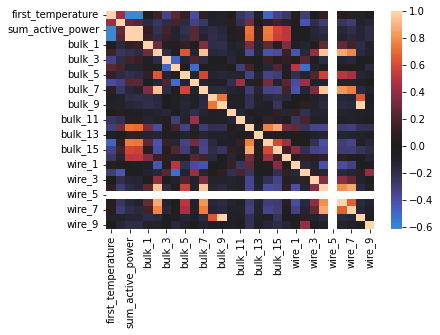

In [746]:
sns.heatmap(corr.corr(), center= 0)

In [747]:
#
data.describe()

,first_temperature,last_temperature,sum_active_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_9
count,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.0,2344.000000,2344.000000,2344.000000
mean,1588.340444,1595.328925,3.129035,3.217577,1.413396,45.850256,34.562713,2.623294,22.020904,1.991894,0.020904,0.441980,4.561860,3.976536,204.320392,0.995307,151.426195,114.135239,11.179831,97.529958,17.277455,3.214215,0.304588,0.0,0.972556,0.006320,0.391471
std,29.307677,15.774437,1.428587,12.016297,19.021277,74.916196,57.285728,22.331461,55.179566,30.578299,1.012086,6.200798,19.940811,21.659154,156.648096,13.837989,83.775214,86.074673,6.340476,46.814490,33.422502,27.854476,4.742555,0.0,8.665779,0.205046,4.254051
min,1191.000000,1541.000000,0.186226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,1572.000000,1587.000000,2.144400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000,7.118725,68.175899,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1587.000000,1593.000000,3.023757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,105.000000,9.956451,100.058403,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,1605.000000,1599.000000,3.910302,0.000000,0.000000,75.000000,69.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,268.500000,0.000000,204.000000,204.000000,13.951185,126.060481,21.170760,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,1679.000000,1700.000000,17.496497,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,90.053604


In [786]:
data = data.drop(data[data['first_temperature'] < 1500].index)

In [787]:
data[data['first_temperature'] <= 1500]['first_temperature'].count()

0

In [788]:
data.describe()

,wire_1,first_temperature,sum_active_power,gas,bulk_6,bulk_14,wire_2,wire_6,bulk_12,bulk_15,bulk_7,bulk_4,bulk_3,last_temperature
count,2340.000000,2340.00000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000
mean,97.490358,1588.98547,3.130545,11.182817,22.058547,151.539316,17.272691,0.974219,204.405128,114.198718,1.995299,34.585897,45.796581,1595.332906
std,46.811799,24.82315,1.428602,6.344082,55.219206,83.776570,33.440251,8.673092,156.725012,86.114896,30.604323,57.312207,74.832397,15.786948
min,0.000000,1519.00000,0.186226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1541.000000
25%,68.175899,1572.00000,2.146877,7.118725,0.000000,104.000000,0.000000,0.000000,105.000000,0.000000,0.000000,0.000000,0.000000,1587.000000
50%,100.042801,1588.00000,3.024206,9.956451,0.000000,149.000000,0.000000,0.000000,206.000000,105.000000,0.000000,0.000000,0.000000,1593.000000
75%,126.027720,1605.00000,3.914388,13.969548,0.000000,204.000000,21.149179,0.000000,270.000000,204.000000,0.000000,69.250000,75.000000,1599.000000
max,330.314424,1679.00000,17.496497,77.995040,503.000000,636.000000,282.780152,180.454575,1849.000000,405.000000,772.000000,281.000000,454.000000,1700.000000


## Разобьем данные

In [789]:
features = data.drop('last_temperature', axis=1)
target = data['last_temperature']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=120922)

In [801]:
features.shape

(2134, 14)

In [802]:
target.shape

(2134,)

## Проведем оценку важности признаков

In [790]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(features, target)

RandomForestRegressor()

In [791]:
df_feature_importance = pd.DataFrame(reg.feature_importances_, index=features.columns.values, columns=['feature importance']).sort_values('feature importance', ascending=False)

In [792]:
df_feature_importance

,feature importance
wire_1,0.307248
first_temperature,0.287014
sum_active_power,0.145921
gas,0.044638
bulk_6,0.035323
bulk_14,0.030148
wire_6,0.027748
wire_2,0.026053
bulk_12,0.025500
bulk_15,0.022698


In [793]:
data_clean = data[list(df_feature_importance.head(13).index)]
data = pd.concat([data_clean, target], axis=1, sort=False)

In [794]:
data

,wire_1,first_temperature,sum_active_power,gas,bulk_6,bulk_14,wire_6,wire_2,bulk_12,bulk_15,bulk_7,bulk_4,bulk_3,last_temperature
key,,,,,,,,,,,,,,
1,60.059998,1571,4.878147,29.749986,0,150,0.0,0.00000,206,154,0,43,0,1613
2,96.052315,1581,3.052598,12.555561,0,149,0.0,0.00000,206,154,0,73,0,1602
3,91.160157,1596,2.525882,28.554793,0,152,0.0,0.00000,205,153,0,34,0,1599
4,89.063515,1601,3.209250,18.841219,0,153,0.0,0.00000,207,154,0,81,0,1625
5,89.238236,1576,3.347173,5.413692,0,151,0.0,9.11456,203,152,0,78,0,1602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,89.150879,1570,3.210690,7.125735,0,129,0.0,0.00000,256,223,0,0,21,1591
2496,114.179527,1554,4.203064,9.412616,0,129,0.0,0.00000,256,226,0,63,0,1591
2497,94.086723,1571,2.212379,6.271699,0,124,0.0,9.04800,230,226,0,85,0,1589


## Проведем поиск аномалий

Для этого воспользуемся простым алгоритмом классификации

Без этого MSE до идеала не доводилось

In [795]:
model = KNN()
data_anomaly = data
model.fit(data_anomaly)
data_anomaly['anomaly'] =  model.predict(data_anomaly) == 1
anomaly_indexes = list(data_anomaly[data_anomaly['anomaly'] == 1].index)
data_knn = data.drop(anomaly_indexes)

In [796]:
len(anomaly_indexes)

206

In [797]:
## Повторно разобьем важные выборки без аномалий

features = data_knn.drop('last_temperature', axis=1)
target = data_knn['last_temperature']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=120922)

## Обучение модели

### LinearRegression

In [805]:
scaler = StandardScaler()
features_train_st = scaler.fit_transform(features_train)
target_train_st = pd.DataFrame(features_train_st, columns=features_train.columns)

In [810]:
%%time
regressor = LinearRegression()
print('# Train for mean_absolute_error')
print()
cv_MAE_LR = (cross_val_score(regressor, 
                             features_train_st, 
                             target_train_st, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE LinearRegression =', cv_MAE_LR)

# Train for mean_absolute_error

MAE LinearRegression = 7.4214490128681465
CPU times: user 141 ms, sys: 5.09 ms, total: 146 ms
Wall time: 42.1 ms


### RandomForestRegressor

In [765]:
%%time
regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 200, 10)], 
                'random_state':[120922]}]
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)
print("Перебор параметров:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1), params))
print()
cv_MAE_RFR = (max(means)*-1)
print()
print("Лучшие параметры")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)

Перебор параметров:

6.0126 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 120922}
6.0072 for {'criterion': 'mse', 'n_estimators': 110, 'random_state': 120922}
6.0064 for {'criterion': 'mse', 'n_estimators': 120, 'random_state': 120922}
6.0058 for {'criterion': 'mse', 'n_estimators': 130, 'random_state': 120922}
6.0039 for {'criterion': 'mse', 'n_estimators': 140, 'random_state': 120922}
6.0081 for {'criterion': 'mse', 'n_estimators': 150, 'random_state': 120922}
6.0118 for {'criterion': 'mse', 'n_estimators': 160, 'random_state': 120922}
6.0137 for {'criterion': 'mse', 'n_estimators': 170, 'random_state': 120922}
6.0127 for {'criterion': 'mse', 'n_estimators': 180, 'random_state': 120922}
6.0102 for {'criterion': 'mse', 'n_estimators': 190, 'random_state': 120922}


Лучшие параметры

{'criterion': 'mse', 'n_estimators': 140, 'random_state': 120922}
CPU times: user 59.6 s, sys: 469 ms, total: 1min
Wall time: 59.5 s


### CatBoostRegressor

In [817]:
regressor = CatBoostRegressor(verbose=False, random_state=120922)
cv_MAE_CBR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE CatBoostRegressor =', cv_MAE_CBR)
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=120922).fit(features_train, 
                                        target_train).get_all_params()
print()
print("Лучшие параметры")
print()
best_params_CBR = clf.best_params_
print(clf.best_params_)

MAE CatBoostRegressor = 5.882103282164961

Лучшие параметры

{'learning_rate': 0.08, 'random_state': 120922, 'silent': True}


### LGBMRegressor

In [767]:
%%time
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(10,15)], 
                'learning_rate':[0.05, 0.07, 0.9],
                'random_state':[120922]}]
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1), params))
print()
cv_MAE_LGBMR = (max(means)*-1)
print()
print("Лучшие параметры:")
print()
best_params_LGBMR = clf.best_params_
print(clf.best_params_)

Grid scores on development set:

6.0976 for {'learning_rate': 0.05, 'num_leaves': 10, 'random_state': 120922}
6.0862 for {'learning_rate': 0.05, 'num_leaves': 11, 'random_state': 120922}
6.0697 for {'learning_rate': 0.05, 'num_leaves': 12, 'random_state': 120922}
6.0645 for {'learning_rate': 0.05, 'num_leaves': 13, 'random_state': 120922}
6.0589 for {'learning_rate': 0.05, 'num_leaves': 14, 'random_state': 120922}
6.0200 for {'learning_rate': 0.07, 'num_leaves': 10, 'random_state': 120922}
6.0384 for {'learning_rate': 0.07, 'num_leaves': 11, 'random_state': 120922}
6.0336 for {'learning_rate': 0.07, 'num_leaves': 12, 'random_state': 120922}
6.0432 for {'learning_rate': 0.07, 'num_leaves': 13, 'random_state': 120922}
6.0261 for {'learning_rate': 0.07, 'num_leaves': 14, 'random_state': 120922}
7.7527 for {'learning_rate': 0.9, 'num_leaves': 10, 'random_state': 120922}
7.7959 for {'learning_rate': 0.9, 'num_leaves': 11, 'random_state': 120922}
8.0574 for {'learning_rate': 0.9, 'num_leaves

### XGBRegressor

In [768]:
%%time
regressor = XGBRegressor() 
hyperparams = [{'learning_rate':[x/100 for x in range(8, 19)],
                'random_state':[120922],
                 'silent':[True]}]
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)
print("Перебор параметров:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
cv_MAE_XGBR = (max(means)*-1)
print()
print("Лучшие параметры:")
print()
best_params_XGBR = clf.best_params_
print(clf.best_params_)

[01:11:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:11:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:11:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x

In [815]:
mae_df = pd.DataFrame( index=['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor', 'XGBRegressor'],
                       data = {'MAE_val':[7.42, 6.00, 5.88, 6.02, 5.87]})
mae_df

,MAE_val
LinearRegression,7.42
RandomForestRegressor,6.00
CatBoostRegressor,5.88
LGBMRegressor,6.02
XGBRegressor,5.87


## Тестирование моделей

### CatBoostRegressor

In [813]:
%%time
model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_CBR = mean_absolute_error(target_predict, target_test)
print('MAE CatBoostRegressor =', test_MAE_CBR)

MAE CatBoostRegressor = 5.716584490037741
CPU times: user 8.57 s, sys: 298 ms, total: 8.87 s
Wall time: 1.45 s


# Вывод

Лучшая модель CatBoostRegressor, MAE = 5.71

Лучшие параметры модели: learning_rate': 0.08, 'random_state': 120922, 'silent': True

Другие модели так же дают хороший результат и могут использоваться для предсказаний.

Для улучшения метрики использовали оценку важности гиперпараметров и поиск аномалий.

# Отчет

В качестве итоговой модели выбран CatBoostRegressor, качество модели по метрике MAE на тестовой выборке составила 5,7 рад.

Описание этапов исследования и полученные результаты

<b>Этап предобоаботки:</b>

Приведение к типу datetime данных, содержащих дату и время технологического процесса во всех таблицах.

Агрегация данных по ключу партии в таблицах, записи в которых не уникальны по ключам (электроды, замеры температуры).

Удаление некорректных данных (реактивная мощность меньше нуля; начальная температура меньше 1500 град)

Соединение данных по ключу партии, тип связи - внутреннее соединение.

<b>Этап обучения:</b>

Разделение данных на обучающую и тестовую выборки в соотношении 3:1

<b>LinearRegression:</b>

Масштабирование признаков

Оценка модели на кросс-валидации для линейной регрессии. Лучшее качество на кросс-валидации MAE=7.42 град. достигнуто при использовании 'n_estimators': 140, 'random_state': 120922

<b>RandomForestRegressor:</b>

Оценка модели на кросс-валидации cо случайным перебором гиперпараметров 'criterion','n_estimators','random_state'.
Определение гиперпараметров из предыдущего пункта: 'mse': 6.0039, 'n_estimators': 140, 'random_state': 120922

<b>CatBoostRegressor:</b>

Оценка модели на кросс-валидации cо случайным перебором гиперпараметров learning_rate', 'random_state', 'silent'. Лучшие гиперпараметры модели: learning_rate': 0.08, 'random_state': 120922, 'silent': True. MAE на кросс-валидации 5.88 град.

Запуск обучения на выбранном наборе гиперпараметров MAE для тестовой выборке 5.71 град.

<b>LGBMRegressor:</b>

Оценка модели на кросс-валидации cо случайным перебором гиперпараметров 'num_leaves', 'learning_rate','random_state'.
Определение гиперпараметров из предыдущего пункта: 'mse': 6.02, 'learning_rate': 0.07, 'num_leaves': 10, 'random_state': 120922.

<b>XGBRegressor:</b>

Оценка модели на кросс-валидации cо случайным перебором гиперпараметров 'learning_rate', 'random_state', 'silent'.
Определение гиперпараметров из предыдущего пункта: 'mse': 5.87, 'learning_rate': 0.08, 'random_state': 120922, 'silent': True.

<b>Этап тестирования:</b>

Оценка качества модели CatBoostRegressor -  MAE=5.71 град.

<b>Вывод:</b>

Обученная модель CatBoostRegressor с подобранными гиперпараметрами рекомендована к использованию для прогнозирования температуры стали.

Для повышения значений МАЕ была произведена оценка важности признаков.

Их значимость по убыванию: 

wire_1, first_temperature

sum_active_power

gas

bulk_6

bulk_14

wire_6

wire_2

bulk_12	

bulk_15

bulk_7	

bulk_4	

bulk_3

Их последующая сортировка и сбор в таблицу "data" позволил более эффективно обучить модели. 

В результате применения выше описанных решений на тестовой выборке для модели "CatBoostRegressor"оценка качества модели MAE = 5.71, тем самым удлаось довести значение MAE < 6.